In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [16]:
class GraphEnvironment:
    def __init__(self, graph, goal_product=1):
        self.graph = graph
        self.goal_product = goal_product
        self.state = self.get_state()
        self.initial_state = self.get_state()

    def initial_state(self):
        """ Initialize the state: a dictionary of node weights. """
        return {str(node):  self.graph.nodes[node]['color'] for node in self.graph.nodes}

    def set_state(self, target_state):
        self.state = target_state
        for node in self.graph.nodes:
            self.graph.nodes[node]['color'] = target_state[str(node)]

    def change_color(self, node):
        self.graph.nodes[node]['color'] = 1 - self.graph.nodes[node]['color']

    def apply_action(self, action):
        """ Apply an action (modify node weights) and return the new state. """
        self.change_color(action)
        for node in self.graph.neighbors(action):
            self.change_color(node)
        self.state = self.get_state()
        return self.state

    def get_state(self):
        return {str(node):  self.graph.nodes[node]['color'] for node in self.graph.nodes}

    def get_reward(self, state):
        """ Reward is based on how close the product of node weights is to the goal. """
        product = 1
        for color in state.values():
            product *= color
        if product == self.goal_product:
            return 100
        elif product == 0:
            return -100
        else:
            return -10

    def is_done(self, state):
        """ Check if the goal is reached (product == 1) or the game should end. """
        product = 1
        for color in state.values():
            product *= color
        return product == self.goal_product

    def get_possible_actions(self):
        """ Return a list of all possible actions. """
        return [node for node in self.graph.nodes]


In [18]:
import random

class QLearningAgent:
    def __init__(self, graph_environment, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = graph_environment
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration factor
        self.q_table = {}  # Q-table, key = state, value = action-value dictionary

    def choose_action(self):
        """ Choose an action using epsilon-greedy approach. """
        state = self.env.get_state()
        state_tuple = tuple(sorted(state.items()))
        if random.random() < self.epsilon:
            return random.choice(self.env.get_possible_actions())
        else:
            if state_tuple not in self.q_table:
                self.q_table[state_tuple] = {action: 0 for action in self.env.get_possible_actions()}
            return max(self.q_table[state_tuple], key=self.q_table[state_tuple].get)

    def learn(self, action, reward, next_state):
        """ Update the Q-table based on the action taken and the received reward. """
        state = self.env.get_state()
        state_tuple = tuple(sorted(state.items()))
        next_state_tuple = tuple(sorted(next_state.items()))
        if state_tuple not in self.q_table:
            self.q_table[state_tuple] = {action: 0 for action in self.env.get_possible_actions()}
        if next_state_tuple not in self.q_table:
            self.q_table[next_state_tuple] = {action: 0 for action in self.env.get_possible_actions()}

        max_next_q_value = max(self.q_table[next_state_tuple].values())  # Maximum Q-value for next state

        # Update Q-value using the Q-learning formula
        self.q_table[state_tuple][action] = self.q_table[state_tuple][action] + self.alpha * (
            reward + self.gamma * max_next_q_value - self.q_table[state_tuple][action])

    def train(self, episodes=1000):
        """ Train the agent over multiple episodes. """
        for episode in range(episodes):
            self.env.set_state(self.env.initial_state)
            done = False
            while not done:
                action = self.choose_action()
                next_state = self.env.apply_action(action)
                reward = self.env.get_reward(next_state)
                done = self.env.is_done(next_state)
                self.learn(action, reward, next_state)
                state = next_state
            if episode % 500 == 0:
                print(f"Episode {episode}: Training...")

In [19]:
# Parameters 2x2 graph
rows = 2
cols = 2

G = nx.Graph()

for row in range(rows):
    for col in range(cols):
        node = (row, col)
        G.add_node(node)
        if (row + col) % 2 == 0:
            G.nodes[node]['color'] = 1
        else:
            G.nodes[node]['color'] = 0

for row in range(rows):
    for col in range(cols):
        node = (row, col)
        if col + 1 < cols:
            G.add_edge(node, (row, col + 1))
        if row + 1 < rows:
            G.add_edge(node, (row + 1, col))


env = GraphEnvironment(G)
agent = QLearningAgent(env)
start_time = datetime.now()
agent.train(episodes=3200)
print(f"Training done. Total time spent: {datetime.now() - start_time}")


Episode 0: Training...
Episode 500: Training...
Episode 1000: Training...
Episode 1500: Training...
Episode 2000: Training...
Episode 2500: Training...
Episode 3000: Training...
Training done. Total time spent: 0:00:00.485653


In [5]:
# remove random
agent.epsilon = 0

In [20]:
def draw_graph(G, pos):
    node_colors = ['black' if G.nodes[node]['color'] == 1 else 'white' for node in G.nodes()]
    fig = plt.figure(figsize=(1.6 * rows, 1.6*cols))
    nx.draw(G, pos, with_labels=True, node_size=20000, node_shape='s', node_color=node_colors, font_size=10, font_weight='bold', edge_color='gray')
    fig.set_facecolor('skyblue')

    plt.title("Puzzle")
    plt.show()

def test_agent(agent, starting_state =None, max_steps=10):
    """
    Function to test the agent's performance after training.

    :param agent: The trained Q-learning agent
    :param max_steps: Maximum number of steps (actions) to test before stopping
    :return: Success (True/False), number of steps taken, and the final state
    """
    if starting_state is None:
        agent.env.state = env.set_state(env.initial_state)
    else:
        agent.env.state = env.set_state(starting_state)

    done = False
    steps_taken = 0

    pos = {(row, col): (col, -row) for row in range(rows) for col in range(cols)}
    draw_graph(G, pos)
    while not done and steps_taken < max_steps:

        action = agent.choose_action()
        next_state = agent.env.apply_action(action)
        reward = agent.env.get_reward(next_state)
        done = agent.env.is_done(next_state)
        print( f"Action = {action}")
        draw_graph(G, pos)

        state = next_state
        steps_taken += 1

    if done:
        print(f"Goal reached in {steps_taken} steps!")
    else:
        print(f"Goal not reached within {max_steps} steps.")

    return done, steps_taken, state

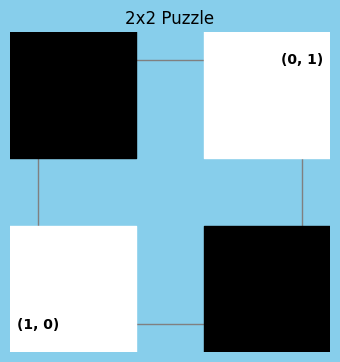

Action = (0, 1)


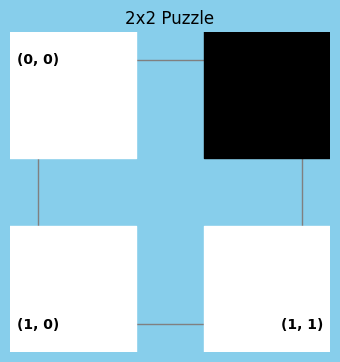

Action = (1, 0)


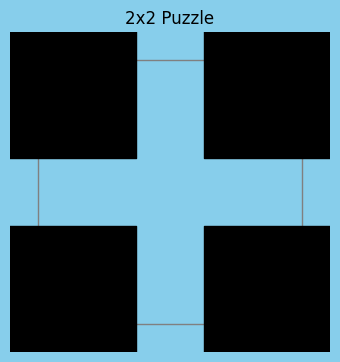

Goal reached in 2 steps!
Success: True, Steps taken: 2, Final state: {'(0, 0)': 1, '(0, 1)': 1, '(1, 0)': 1, '(1, 1)': 1}


In [7]:
# Testing the agent after training
success, steps, final_state = test_agent(agent)
print(f"Success: {success}, Steps taken: {steps}, Final state: {final_state}")

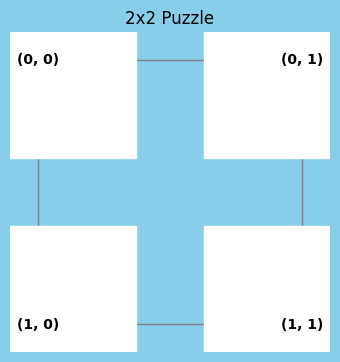

Action = (1, 0)


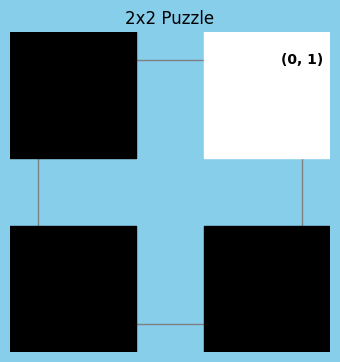

Action = (0, 1)


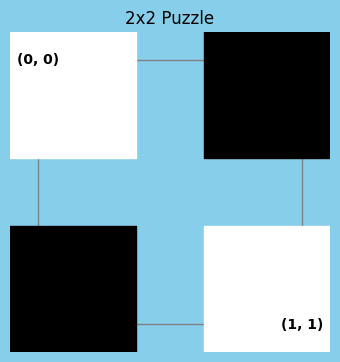

Action = (1, 0)


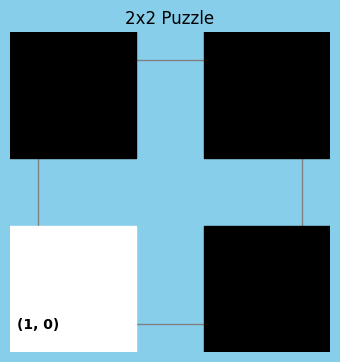

Action = (0, 0)


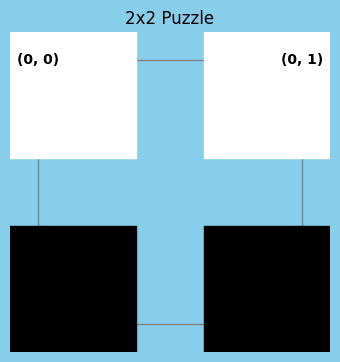

Action = (1, 0)


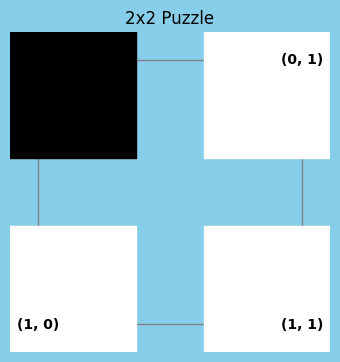

Action = (1, 1)


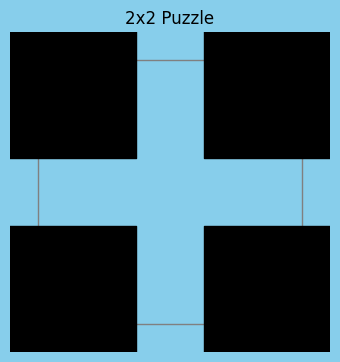

Goal reached in 6 steps!
Success: True, Steps taken: 6, Final state: {'(0, 0)': 1, '(0, 1)': 1, '(1, 0)': 1, '(1, 1)': 1}


In [8]:
success, steps, final_state = test_agent(agent, starting_state={'(0, 0)': 0, '(0, 1)': 0, '(1, 0)': 0, '(1, 1)': 0})
print(f"Success: {success}, Steps taken: {steps}, Final state: {final_state}")

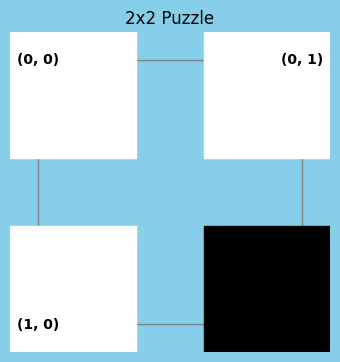

Action = (0, 0)


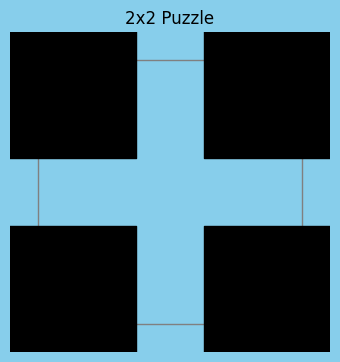

Goal reached in 1 steps!
Success: True, Steps taken: 1, Final state: {'(0, 0)': 1, '(0, 1)': 1, '(1, 0)': 1, '(1, 1)': 1}


In [9]:
success, steps, final_state = test_agent(agent, starting_state={'(0, 0)': 0, '(0, 1)': 0, '(1, 0)': 0, '(1, 1)': 1})
print(f"Success: {success}, Steps taken: {steps}, Final state: {final_state}")

In [22]:
# Parameters
rows = 3
cols = 3

G = nx.Graph()

for row in range(rows):
    for col in range(cols):
        node = (row, col)
        G.add_node(node)
        G.nodes[node]['color'] = 0

for row in range(rows):
    for col in range(cols):
        node = (row, col)
        if col + 1 < cols:
            G.add_edge(node, (row, col + 1))
        if row + 1 < rows:
            G.add_edge(node, (row + 1, col))


env = GraphEnvironment(G)
agent = QLearningAgent(env)
start_time = datetime.now()
agent.train(episodes=32000)
print(f"Training done. Total time spent: {datetime.now() - start_time}")

Episode 0: Training...
Episode 500: Training...
Episode 1000: Training...
Episode 1500: Training...
Episode 2000: Training...
Episode 2500: Training...
Episode 3000: Training...
Episode 3500: Training...
Episode 4000: Training...
Episode 4500: Training...
Episode 5000: Training...
Episode 5500: Training...
Episode 6000: Training...
Episode 6500: Training...
Episode 7000: Training...
Episode 7500: Training...
Episode 8000: Training...
Episode 8500: Training...
Episode 9000: Training...
Episode 9500: Training...
Episode 10000: Training...
Episode 10500: Training...
Episode 11000: Training...
Episode 11500: Training...
Episode 12000: Training...
Episode 12500: Training...
Episode 13000: Training...
Episode 13500: Training...
Episode 14000: Training...
Episode 14500: Training...
Episode 15000: Training...
Episode 15500: Training...
Episode 16000: Training...
Episode 16500: Training...
Episode 17000: Training...
Episode 17500: Training...
Episode 18000: Training...
Episode 18500: Training..

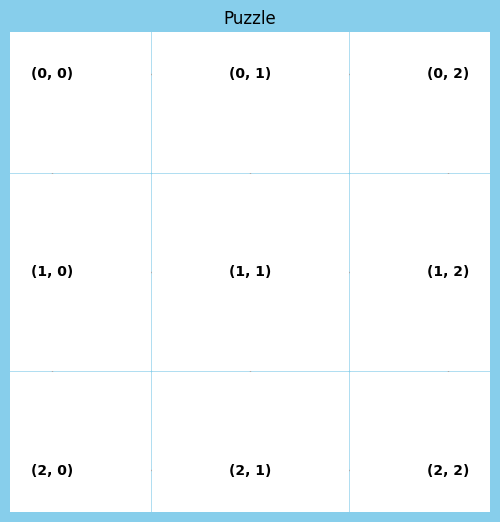

Action = (1, 2)


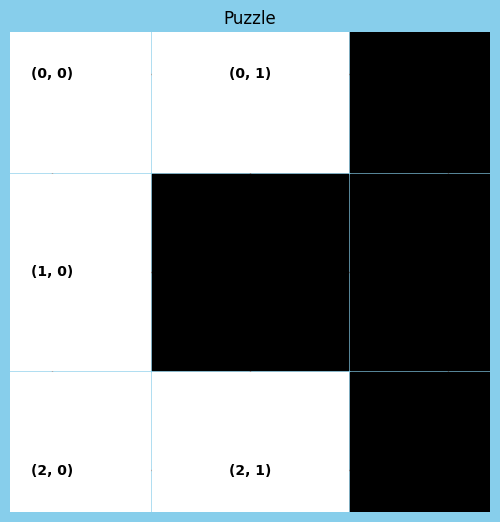

Action = (0, 1)


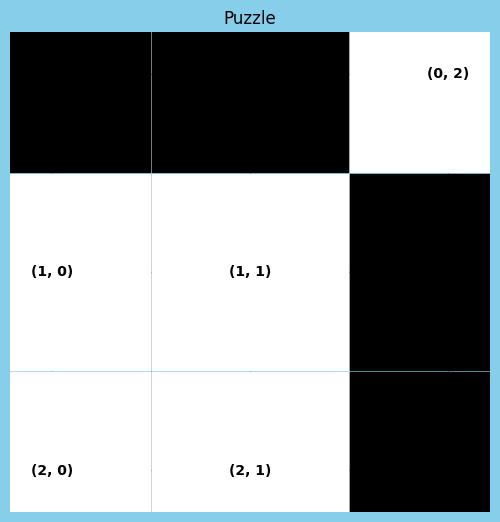

Action = (2, 2)


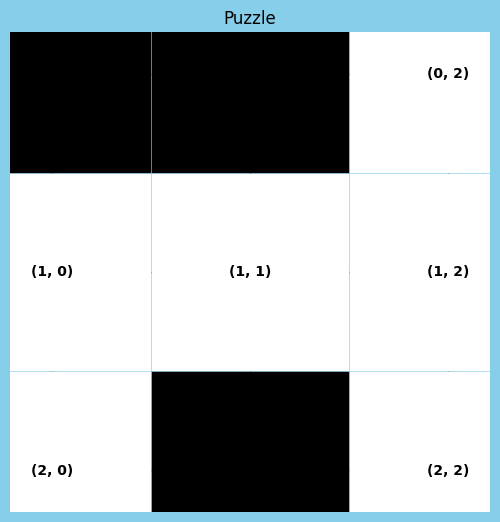

Action = (0, 0)


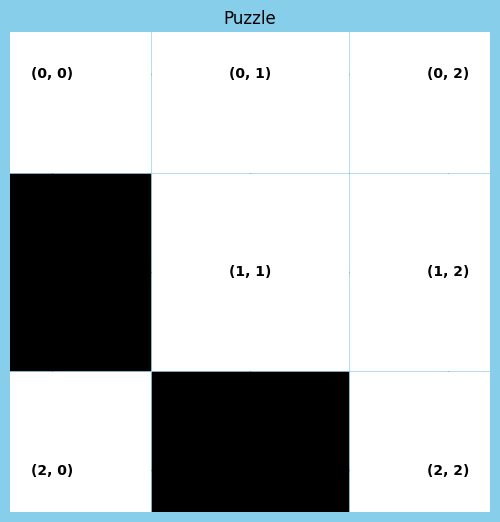

Action = (2, 1)


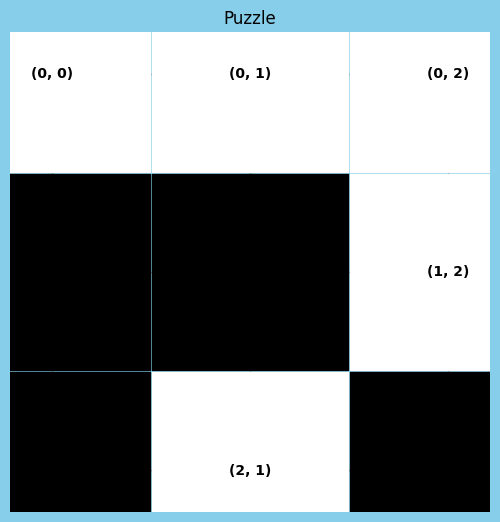

Action = (1, 1)


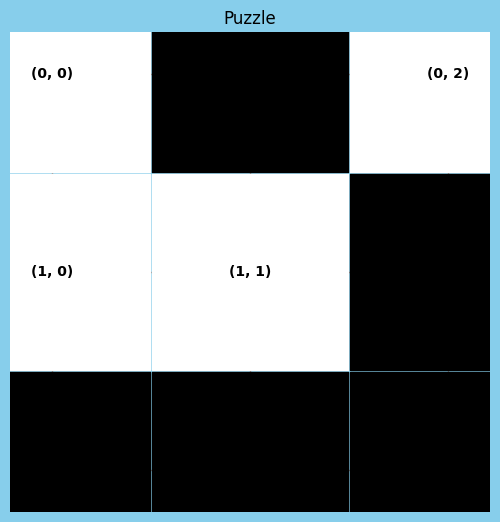

Action = (0, 0)


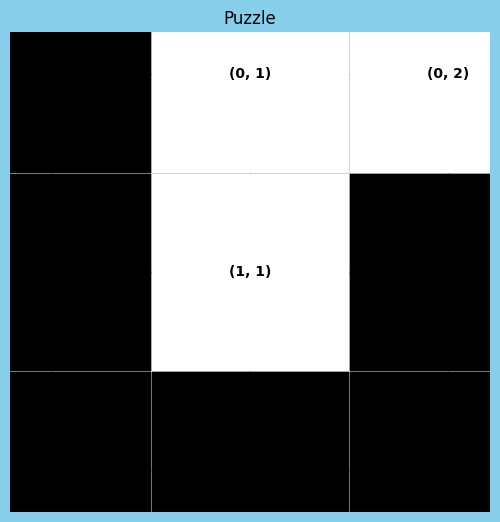

Action = (2, 2)


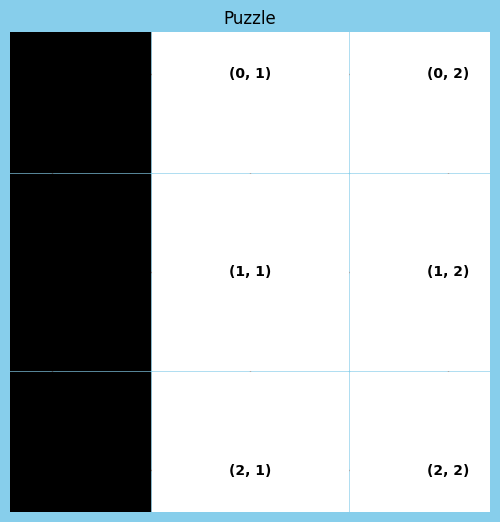

Action = (0, 2)


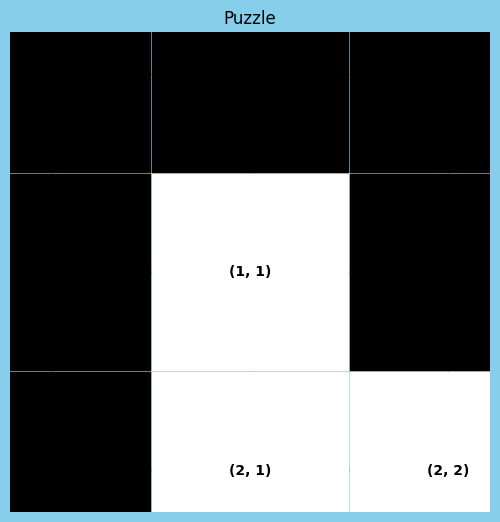

Action = (1, 1)


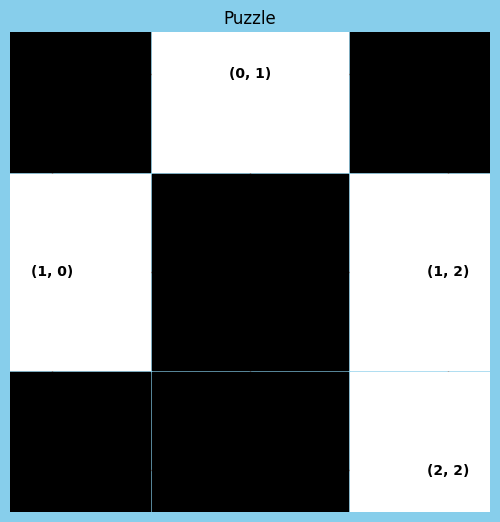

Action = (2, 2)


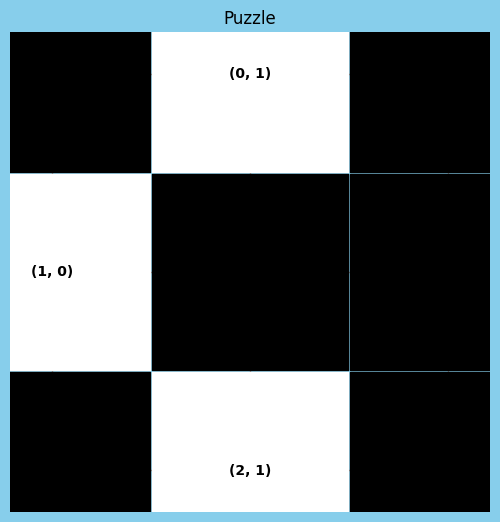

Action = (1, 1)


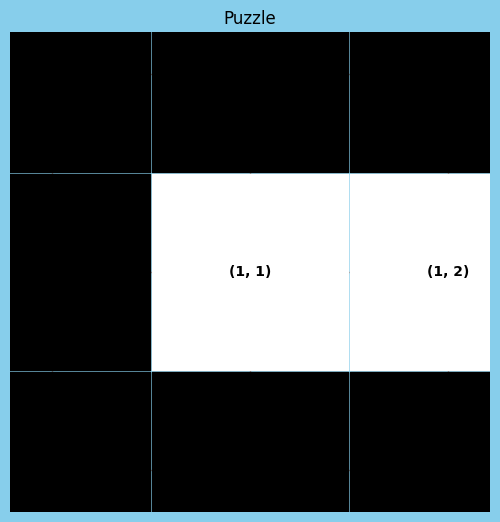

Action = (2, 1)


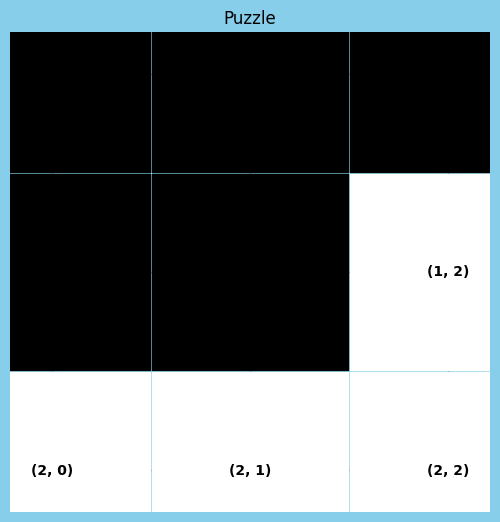

Action = (2, 0)


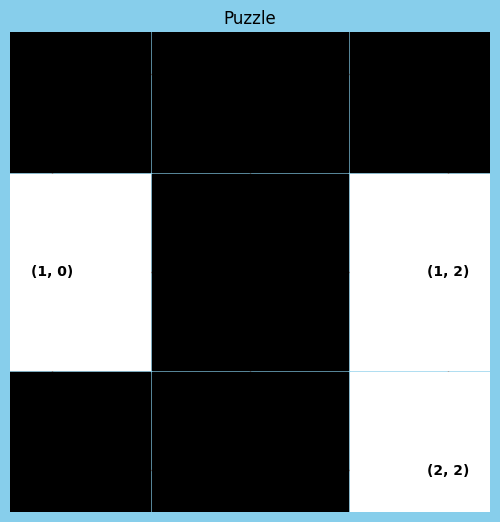

Action = (0, 1)


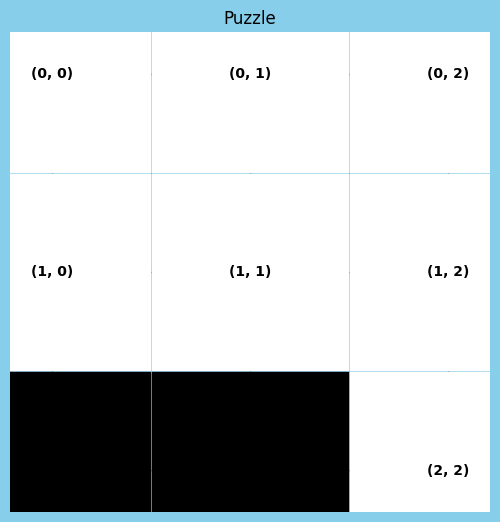

Action = (2, 1)


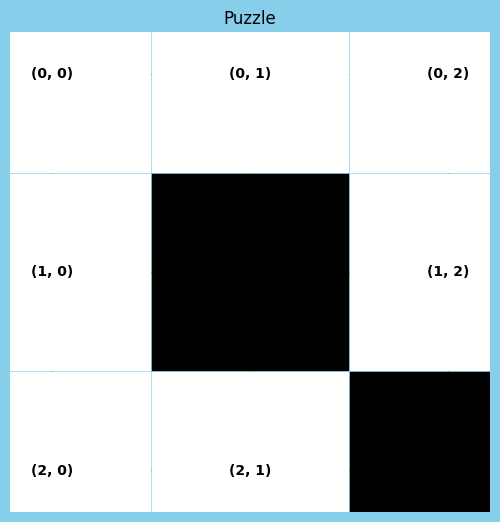

Action = (1, 0)


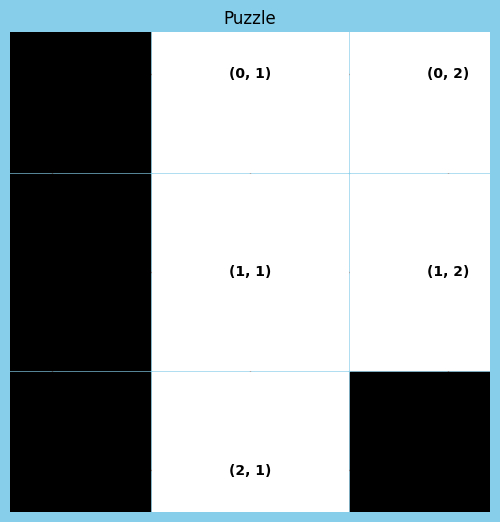

Action = (0, 0)


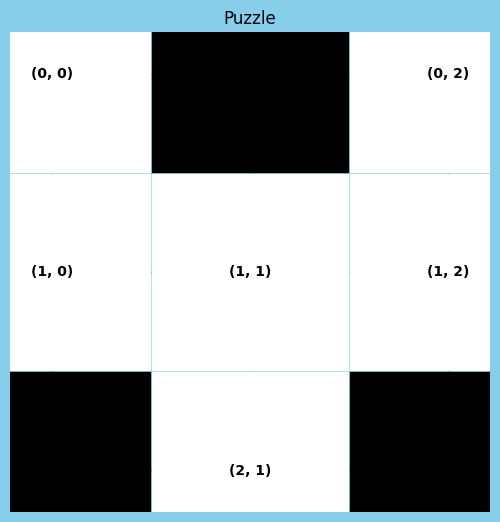

Action = (2, 0)


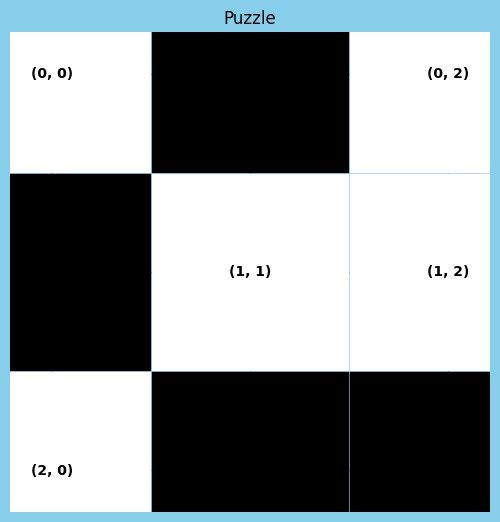

Action = (2, 1)


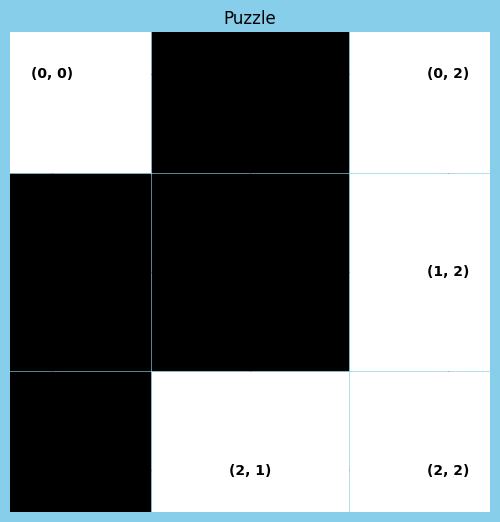

Goal not reached within 20 steps.
Success: False, Steps taken: 20, Final state: {'(0, 0)': 0, '(0, 1)': 1, '(0, 2)': 0, '(1, 0)': 1, '(1, 1)': 1, '(1, 2)': 0, '(2, 0)': 1, '(2, 1)': 0, '(2, 2)': 0}


In [23]:
# remove random
agent.epsilon = 0
# Testing the agent after training
success, steps, final_state = test_agent(agent, max_steps=20)
print(f"Success: {success}, Steps taken: {steps}, Final state: {final_state}")


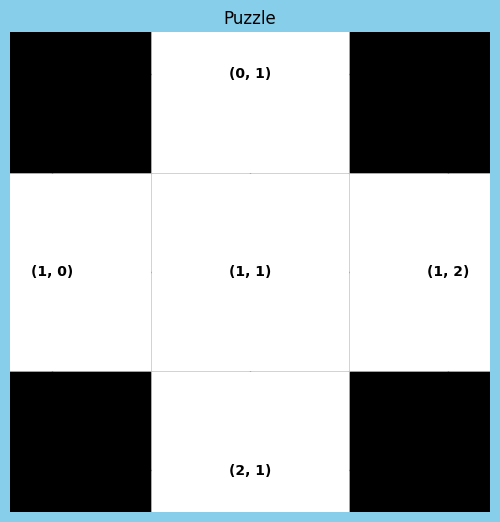

Action = (1, 1)


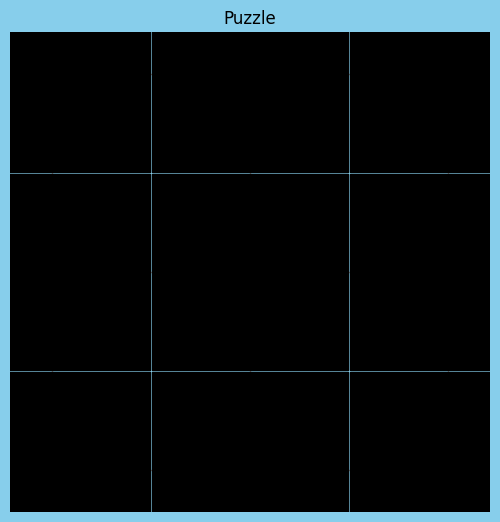

Goal reached in 1 steps!
Success: True, Steps taken: 1, Final state: {'(0, 0)': 1, '(0, 1)': 1, '(0, 2)': 1, '(1, 0)': 1, '(1, 1)': 1, '(1, 2)': 1, '(2, 0)': 1, '(2, 1)': 1, '(2, 2)': 1}


In [24]:
success, steps, final_state = test_agent(agent, max_steps = 20 , starting_state={'(0, 0)': 1, '(0, 1)': 0, '(0, 2)': 1, '(1, 0)': 0, '(1, 1)': 0, '(1, 2)': 0, '(2, 0)': 1, '(2, 1)': 0, '(2, 2)': 1})
print(f"Success: {success}, Steps taken: {steps}, Final state: {final_state}")

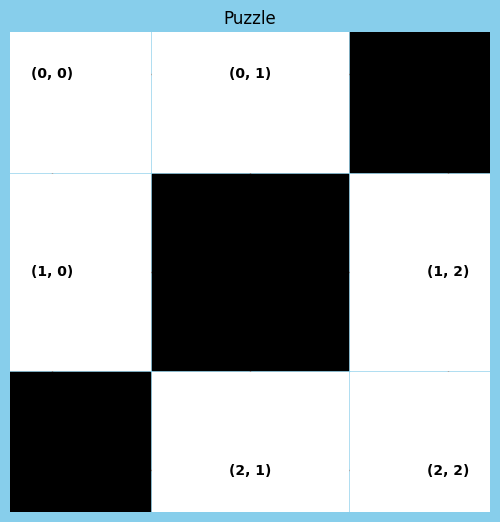

Action = (2, 2)


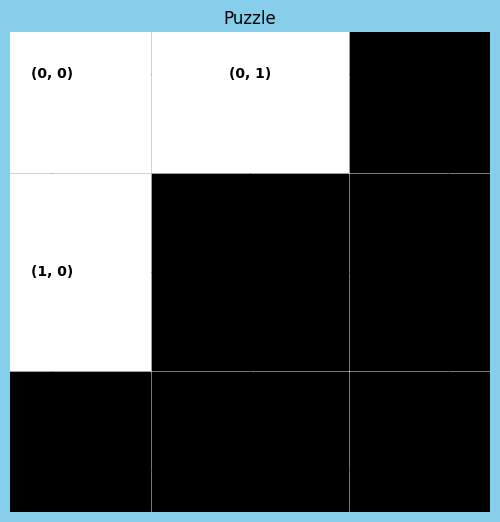

Action = (0, 0)


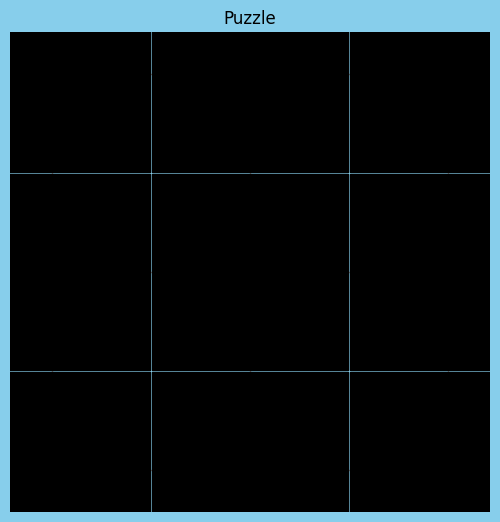

Goal reached in 2 steps!
Success: True, Steps taken: 2, Final state: {'(0, 0)': 1, '(0, 1)': 1, '(0, 2)': 1, '(1, 0)': 1, '(1, 1)': 1, '(1, 2)': 1, '(2, 0)': 1, '(2, 1)': 1, '(2, 2)': 1}


In [25]:
success, steps, final_state = test_agent(agent, max_steps=20, starting_state={'(0, 0)': 0, '(0, 1)': 0, '(0, 2)': 1, '(1, 0)': 0, '(1, 1)': 1, '(1, 2)': 0, '(2, 0)': 1, '(2, 1)': 0, '(2, 2)': 0})
print(f"Success: {success}, Steps taken: {steps}, Final state: {final_state}")